# Extrapolation - Parceling 
- Para utilizar esse método é necessário já ter um modelo de credit score em produção, uma vez que esse depende da taxa de inadimplência por faixa de escore entre os clientes aceitos.
- Supõe-se, para essa técnica, que clientes com mesmo escore têm o mesmo comportamento.
- Após treinar um modelo com os aprovados (modelo KGB), são definidas faixas de risco considerando os escores de aprovados e reprovados.
- Para cada grupo de risco são calculadas as proporções de aprovados maus e bons. Daí atribuímos aleatoriamente aos reprovados de cada faixa o default nas proporções observadas.
- Como é provável que os clientes recusados sejam naturalmente mais arriscados, podemos trabalhar com um fator (lambda, superior a 1) de ponderação da proporção aplicada em cada faixa.

In [1]:
import sys
sys.path.append('C:\\git\\reject-inference-toy-examples\\')
from reject_inference.utils.helpers import CreditMetrics
from reject_inference.main import RejectInference

import pandas as pd
import random
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns

from optbinning import OptimalBinning

In [2]:
df = pd.read_csv("../data/credit_data.csv").dropna().drop_duplicates()

## Modelagem com aprovados

In [3]:
# Step 0: Dividir amostra entre aprovados e rejeitados para a simulação
X_aprovados, X_rejeitados, y_aprovados, y_rejeitados = train_test_split(
    df.drop(columns=['default', 'clientid']), df['default'], test_size=0.3, random_state=42
)

In [4]:
# Step 1: Construir modelo na população conhecida (KGB)
scorecard_A = LogisticRegression()
scorecard_A.fit(X_aprovados, y_aprovados)

LogisticRegression()

In [5]:
# Step 1.1: Criar faixas de risco (com optimal binning)
prob_bom_aprovados = scorecard_A.predict_proba(X_aprovados)[:, 0]
X_aprovados['prob_0_ScA'] = prob_bom_aprovados

In [6]:
X = X_aprovados['prob_0_ScA'].values
y = y_aprovados.values
optbin = OptimalBinning(name='pred_prob', dtype='numerical', solver='cp',
                        min_n_bins=5,
                        max_n_bins=20, 
                        # min_prebin_size=0.05,
                        # max_bin_size=0.10,
                        # min_event_rate_diff=0.015,
                        min_bin_size=0.05
                        )

optbin.fit(X, y)
print(optbin.status)

OPTIMAL


In [7]:
binning_table = optbin.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.38)",90,0.064378,12,78,0.866667,-3.764815,1.567492,0.127556
1,"[0.38, 0.76)",123,0.087983,55,68,0.552846,-2.105188,0.686959,0.072862
2,"[0.76, 0.85)",74,0.052933,56,18,0.243243,-0.758033,0.039622,0.004838
3,"[0.85, 0.91)",70,0.050072,56,14,0.200000,-0.506719,0.015410,0.001906
4,"[0.91, inf)",1041,0.744635,1036,5,0.004803,3.440671,2.839767,0.244102
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,1398,1.000000,1215,183,0.130901,,5.149251,0.451264


In [8]:
bins = optbin.splits
bins = np.insert(bins, 0, 0)
bins = np.insert(bins, len(bins), 1)
labels = [i for i in range(1, (len(bins)))]

In [9]:
X_aprovados['faixas_risco'] = pd.cut(X_aprovados.prob_0_ScA, bins=bins, labels=labels)

In [10]:
bad_rate_por_faixa = pd.crosstab(X_aprovados.faixas_risco,
                                 y_aprovados,
                                 normalize='index').reset_index().rename(columns={1: 'Bad_Rate'})

In [11]:
bad_rate_por_faixa

default,faixas_risco,0,Bad_Rate
0,1,0.134831,0.865169
1,2,0.447154,0.552846
2,3,0.756757,0.243243
3,4,0.800000,0.200000
4,5,0.995197,0.004803


## Inferência de rejeitados

In [12]:
# Step 2: Estimar probabilidade de ser BOM nos rejeitados com o modelo feito baseado no KGB
p_good_rejeitados = scorecard_A.predict_proba(X_rejeitados)[:, 0]

In [13]:
# Step 2.1: Encontrar a faixa de risco de acordo com o modelo KGB, com sua respetiva bad rate
X_rejeitados['faixas_risco'] = pd.cut(p_good_rejeitados, bins=bins, labels=labels)
rejeitados = X_rejeitados.merge(bad_rate_por_faixa[['faixas_risco', 'Bad_Rate']],
                                on='faixas_risco')

In [14]:
# Step 3: Gerar performance dos rejeitados usando parceling simples
infer = RejectInference(data=rejeitados,
                        bad_rate_column='Bad_Rate',
                        target_column_future_name='default')

rejeitados_inferidos = infer.parceling(fator_lambda=1.5)

In [15]:
pd.crosstab(rejeitados_inferidos.faixas_risco,
            rejeitados_inferidos.default,
            normalize='index').multiply(100).round(2).reset_index().rename(columns={1: 'Bad_Rate'})

default,faixas_risco,0,Bad_Rate
0,1.0,0.00,100.00
1,2.0,25.35,74.65
2,3.0,61.54,38.46
3,4.0,62.16,37.84
4,5.0,99.29,0.71


## Modelagem com aprovados e reprovados

In [16]:
cols = ['income', 'age', 'loan']

aprovados = pd.concat([X_aprovados[cols], y_aprovados], axis=1)
rejeitados = rejeitados_inferidos[cols + ['default']].copy()

# Adiciona coluna de referência
aprovados['ref'] = 'kgb'
rejeitados['ref'] = 'infer'

# Une aprovados e rejeitados:
df_final = pd.concat([aprovados, rejeitados], axis=0)

In [17]:
# Step 4: Modelar com KGB + inferidos
# Step 4.1: Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    df_final[cols],
    df_final['default'],
    test_size=0.2, random_state=42
)

In [18]:
scorecard_B = LogisticRegression()
scorecard_B.fit(X_train, y_train)

LogisticRegression()

## Resultados do Modelo

In [19]:
y_pred = scorecard_B.predict(X_test)

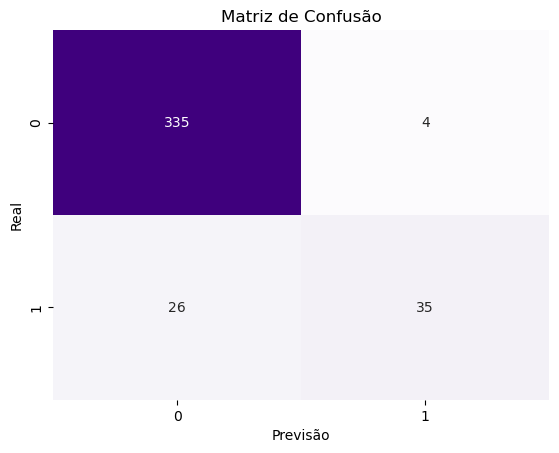

In [20]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", cbar=False)
plt.xlabel("Previsão")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       339
           1       0.90      0.57      0.70        61

    accuracy                           0.93       400
   macro avg       0.91      0.78      0.83       400
weighted avg       0.92      0.93      0.92       400



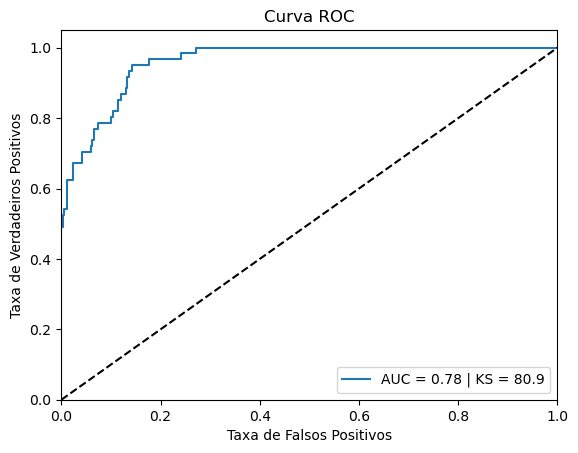

In [22]:
fpr, tpr, thresholds = roc_curve(y_test, scorecard_B.predict_proba(X_test)[:, 1])
auc = roc_auc_score(y_test, y_pred)
ks = np.max(np.abs(tpr - fpr))

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f} | KS = {100*ks:.1f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Métricas de crédito para comparação das técnicas

In [23]:
metricas = CreditMetrics(data = df_final,
                         target_column = 'default',
                        inference_reference_column = 'ref')

metricas.generate_report(y_train, 
                        scorecard_B.predict(X_train),
                        y_test,
                        scorecard_B.predict(X_test),)

,Overall Bad Rate,Known GB Odds/Inferred GB Odds,Gini Dev,Gini Test,Overfitting (gini_dev - gini_test)
0,15.22,1.68,55.18,56.2,-1.02
